In [11]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import os 
import matplotlib.animation as animation
from scipy import stats

data_dir = '/mnt/ceph/users/lvanson/CompasOutput/v02.41.06/N1e6_Fiducial_NSNS/'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize



def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass   

# Make animations of the NSNS mass distribution as a funciton of redshift


<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'redshifts']>
(46980,)
(3398,)
(3398, 100)
(100,)
<KeysViewHDF5 ['BSE_Common_Envelopes', 'BSE_Double_Compact_Objects', 'BSE_RLOF', 'BSE_Supernovae', 'BSE_System_Parameters', 'Run_Details']>
!!!!!!!! <KeysViewHDF5 ['Coalescence_Time', 'Eccentricity@DCO', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Record_Type', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time', 'mixture_weight']>


SEED,Mass(1),Mass(2),mixture_weight,Stellar_Type(1),Stellar_Type(2),Merges_Hubble_Time,M_moreMassive,M_lessMassive,Mchirp
uint64,float64,float64,float64,int32,int32,uint8,float64,float64,float64
5447,1.200401652437642,1.858453741009528,0.02626198389256116,13,13,1,1.858453741009528,1.200401652437642,1.294121983716249
18141,1.2600165493083972,1.2028168007463131,0.024707780777750526,13,13,1,1.2600165493083972,1.2028168007463131,1.0716634913980454
19981,1.202593720811601,1.235090007913711,0.029874232754264995,13,13,1,1.235090007913711,1.202593720811601,1.0609503303795778
54622,1.2601636843543564,1.1916328232283504,0.013087784866142824,13,13,1,1.2601636843543564,1.1916328232283504,1.066706068622147
68444,1.260124645676723,1.2078189629541853,0.02349575567728352,13,13,1,1.260124645676723,1.2078189629541853,1.0739453038540798
73895,1.2600141969520549,1.4421023841981822,0.02526739102488151,13,13,1,1.4421023841981822,1.2600141969520549,1.1729570327081893
77556,1.260116423309937,1.7485328433297023,0.017340972499014694,13,13,1,1.7485328433297023,1.260116423309937,1.2887728163517103
80047,1.2600144012539962,1.426694000310983,0.021587777792781978,13,13,1,1.426694000310983,1.2600144012539962,1.1667550776743487
87990,1.260093226561926,1.6098057075587169,0.007749259824457244,13,13,1,1.6098057075587169,1.260093226561926,1.238033405738868


MovieWriter ffmpeg unavailable; using Pillow instead.


/tmp/ipykernel_647304/490000480.py:81: RuntimeWarning: invalid value encountered in true_divide
  y_vals = hist / Mbinwidth / norm
/mnt/sw/nix/store/b4q5asj8flwlgmaijgj1r6wbmnls5x8k-python-3.9.15-view/lib/python3.9/site-packages/scipy/stats/_kde.py:200: RuntimeWarning: invalid value encountered in true_divide
  self._weights /= sum(self._weights)


ValueError: array must not contain infs or NaNs

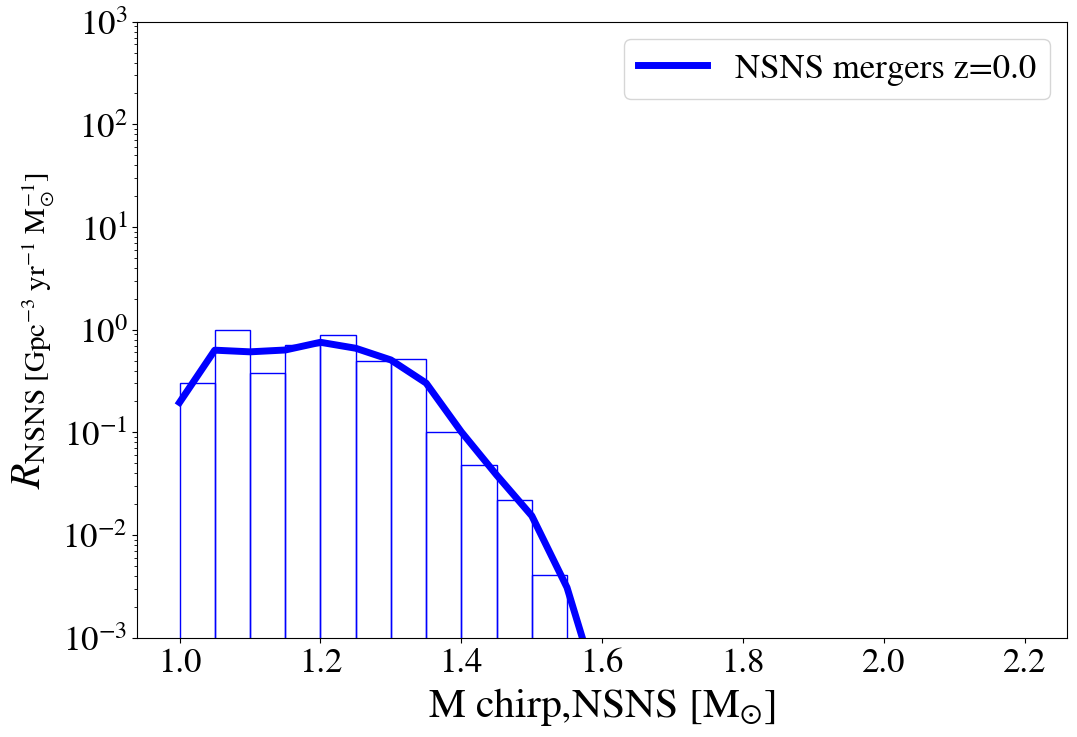

In [20]:
####################################
# Read the rates data
# Open the HDF5 file containing the rates data
print()
File = h5.File(data_dir+'/CosmicIntegration/Rate_info.h5', 'r')

# Set the key for the simulation data to analyze
sim_key = 'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'

# Print the keys in the simulation data
print(File[sim_key].keys())

# Print the shape of each dataset in the simulation data
for key in File[sim_key].keys():
    print(np.shape(File[sim_key][key][()]))

####################################
# Read COMPAS simulation data
# Open the HDF5 file containing the COMPAS simulation data
dataFile = h5.File(data_dir+'/MainRun/COMPAS_Output_wWeights.h5', 'r')

# Print the keys in the COMPAS simulation data
print(dataFile.keys())

# Set the key for the double compact object (DCO) data
DCO_key = 'BSE_Double_Compact_Objects'
print('!!!!!!!!', dataFile[DCO_key].keys())
# Set the list of keys to extract from the DCO data
key_list = ['SEED', 'Mass(1)','Mass(2)','mixture_weight', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Merges_Hubble_Time']
#'Metallicity@ZAMS(1)', 'Immediate_RLOF>CE', 'Optimistic_CE',

# Create an empty table to store the DCO data
DCO = Table()

# Extract the DCO data for each key in the list
for key in key_list:
    DCO[key] = dataFile[DCO_key][key][()]

# Calculate the more massive and less massive component masses and chirp mass
DCO['M_moreMassive'] = np.maximum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
DCO['M_lessMassive'] = np.minimum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
DCO['Mchirp'] = Mchirp(DCO['M_moreMassive'], DCO['M_lessMassive'])

# Reduce the DCO table to only NSNS that merge in a Hubble time
NSNStable = DCO[File[sim_key]['DCOmask'][()]]

display(NSNStable)

####################################
# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(12, 8))

# Define the bins and x values for the KDE
Mbinwidth = 0.05
mass_key = 'chirp'#'_lessMassive' # 
bins = np.arange(1, 2.2, Mbinwidth)
x_KDE = np.arange(1, 2.2, 0.05)

# Define whether to normalize the histogram by its peak value
normalize_by_peak = True

# Create the animation function
def animate(i):
    # Clear the axis
    ax.clear()

    # Extract the rates and redshift for the current frame
    rates = File[sim_key]['merger_rate'][()]
    redshifts = File[sim_key]['redshifts'][()]
    redshift_i = i % len(redshifts)

    # Plot the histogram
    hist, bin_edge = np.histogram(NSNStable[f'M{mass_key}'], weights=rates[:, redshift_i], bins=bins)
    center_bins = (bin_edge[:-1] + bin_edge[1:]) / 2.

    if normalize_by_peak:
        norm = max(hist / Mbinwidth)
    else:
        norm = 1.

    y_vals = hist / Mbinwidth / norm
    ax.bar(center_bins, y_vals, width=np.diff(bins),
        alpha=1.0, fill=False, edgecolor='blue', lw=1.)

    # Plot the KDE
    kernel = stats.gaussian_kde(NSNStable[f'M{mass_key}'], weights=rates[:, redshift_i], bw_method='silverman')
    KDEy_vals = kernel(x_KDE) * sum(hist) / norm  # re-normalize the KDE
    ax.plot(x_KDE, KDEy_vals, label=f'NSNS mergers z={np.round(redshifts[redshift_i],2)}' , color='blue', lw=5)

    # Set the axis labels and limits
    ax.set_xlabel(f'M {mass_key},NSNS '+ '$[\mathrm{M_{\odot}} ]$', fontsize=30)
    ax.set_ylabel('$R_{\mathrm{NSNS} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}}]}$', fontsize=30)
    ax.set_yscale('log')
    ax.set_ylim(1e-3, 1e3)
    ax.legend()

# Create the animation object
ani = animation.FuncAnimation(fig, animate, frames=len(File[sim_key]['redshifts']), interval=500) 

# Save the animation as a GIF file
# ani.save(data_dir+sim+'/output/Rates/NSNS_merger_rates.gif')
ani.save(f'../plots/NSNS_merger_rates_M{mass_key}.gif')

# Show the animation
plt.show()




# Read and extract essential data to one hdf5 file

In [12]:

# Define the list of simulations to analyze
simulations = os.listdir(data_dir)
sim_list = [sim for sim in simulations if sim not in ['EssentialData', 'Grid_Call_Stroopwafel.py']]

# Define the list of keys to extract from the DCO data
key_list = ['SEED', 'Metallicity@ZAMS(1)', 'Mass(1)', 'Mass(2)', 'mixture_weight',
            'Stellar_Type(1)', 'Stellar_Type(2)', 'Immediate_RLOF>CE', 'Optimistic_CE', 'Merges_Hubble_Time']

# Define the name of the output HDF5 file
output_file = 'all_simulations.h5'

# Loop over all simulations
with h5.File(data_dir+output_file, 'w') as f:
    for sim in sim_list:

        try:
            # Create a group for the current simulation
            sim_group = f.create_group(sim)

            # Open the HDF5 file containing the rates data
            File = h5.File(data_dir+sim+'/output/Rates/Rate_info.h5', 'r')

            # Set the key for the simulation data to analyze
            SFRD_key = 'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned'

            # Open the HDF5 file containing the COMPAS simulation data
            dataFile = h5.File(data_dir+sim+'/output/COMPAS_Output_wWeights.h5', 'r')

            # Extract the DCO data for each key in the list
            DCO = Table()
            for key in key_list:
                DCO[key] = dataFile['BSE_Double_Compact_Objects'][key][()]

            # Calculate the more massive and less massive component masses and chirp mass
            DCO['M_moreMassive'] = np.maximum(dataFile['BSE_Double_Compact_Objects']['Mass(1)'][()], dataFile['BSE_Double_Compact_Objects']['Mass(2)'][()])
            DCO['M_lessMassive'] = np.minimum(dataFile['BSE_Double_Compact_Objects']['Mass(1)'][()], dataFile['BSE_Double_Compact_Objects']['Mass(2)'][()])
            DCO['Mchirp'] = Mchirp(DCO['M_moreMassive'], DCO['M_lessMassive'])

            # Reduce the DCO table to only NSNS that merge in a Hubble time
            NSNStable = DCO[File[SFRD_key]['DCOmask'][()]]

            # Save the NSNS table to the HDF5 file
            dco_group = sim_group.create_group('NSNS')
            for dco_key in NSNStable.keys():
                dco_group.create_dataset(dco_key, data=NSNStable[dco_key][()])

            # Save the Rate info to the HDF5 file
            rate_group = sim_group.create_group('Rate_info')
            for key in File[SFRD_key].keys():
                rate_group.create_dataset(key, data=File[SFRD_key][key][()])
        except:
            print('error for ', sim)
            continue

error for  faccFIXEDbeta0.5gammaMIXTUREfcircum0.75zetaHG6.0RemMassFRYER2012SNDELAYEDoutput
